Imports

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_rel, wilcoxon


Paths

In [5]:
import os

PROJECT_ROOT = r"c:\BudgetAware_HPO_Dissertation"

BASELINE_DIR = os.path.join(PROJECT_ROOT, "results", "baselines")
HPO_DIR = os.path.join(PROJECT_ROOT, "results", "hpo")

BASELINE_FILES = {
    "adult": os.path.join(BASELINE_DIR, "mlp_baseline_adult.csv"),
    "credit-g": os.path.join(BASELINE_DIR, "mlp_baseline_credit-g.csv"),
}

HPO_SUMMARY_FILE = os.path.join(HPO_DIR, "mlp_hpo_summary.csv")

print("PROJECT_ROOT:", PROJECT_ROOT)
print("BASELINE_DIR:", BASELINE_DIR)
print("BASELINE_FILES:", BASELINE_FILES)
print("HPO_DIR:", HPO_DIR)
print("HPO_SUMMARY_FILE:", HPO_SUMMARY_FILE)


PROJECT_ROOT: c:\BudgetAware_HPO_Dissertation
BASELINE_DIR: c:\BudgetAware_HPO_Dissertation\results\baselines
BASELINE_FILES: {'adult': 'c:\\BudgetAware_HPO_Dissertation\\results\\baselines\\mlp_baseline_adult.csv', 'credit-g': 'c:\\BudgetAware_HPO_Dissertation\\results\\baselines\\mlp_baseline_credit-g.csv'}
HPO_DIR: c:\BudgetAware_HPO_Dissertation\results\hpo
HPO_SUMMARY_FILE: c:\BudgetAware_HPO_Dissertation\results\hpo\mlp_hpo_summary.csv


Load data

In [6]:
import os

print("Baseline dir exists:", os.path.exists(BASELINE_DIR))
print("Baseline dir contents:", os.listdir(BASELINE_DIR))
print("HPO dir exists:", os.path.exists(HPO_DIR))
print("HPO dir contents:", os.listdir(HPO_DIR))


Baseline dir exists: True
Baseline dir contents: ['mlp_baseline_adult.csv', 'mlp_baseline_credit-g.csv']
HPO dir exists: True
HPO dir contents: ['mlp_hpo_cv_results.csv', 'mlp_hpo_summary.csv']


In [10]:
baseline = []
for ds, path in BASELINE_FILES.items():
    df = pd.read_csv(path)
    df["dataset"] = ds  # ensure consistent
    baseline.append(df)

baseline_df = pd.concat(baseline, ignore_index=True)

hpo_df = pd.read_csv(HPO_SUMMARY_FILE)

print("Baseline columns:", baseline_df.columns.tolist())
print("HPO columns:", hpo_df.columns.tolist())

baseline_df.head(), hpo_df.head()


Baseline columns: ['dataset', 'seed', 'f1_macro']
HPO columns: ['dataset', 'method', 'run_seed', 'best_cv_f1', 'test_f1', 'clf__alpha', 'clf__hidden_layer_sizes', 'clf__learning_rate_init', 'clf__max_iter']


(  dataset  seed  f1_macro
 0   adult     0  0.793289
 1   adult     1  0.787800
 2   adult     2  0.786202
 3   adult     3  0.786437
 4   adult     4  0.780199,
   dataset                 method  run_seed  best_cv_f1   test_f1  clf__alpha  \
 0   adult          random_search         0    0.792137  0.800828    0.022096   
 1   adult  halving_random_search         0    0.787949  0.776320    0.000345   
 2   adult          random_search         1    0.792239  0.801691    0.000033   
 3   adult  halving_random_search         1    0.784253  0.797404    0.000033   
 4   adult          random_search         2    0.791792  0.788537    0.093986   
 
   clf__hidden_layer_sizes  clf__learning_rate_init  clf__max_iter  
 0                   (50,)                 0.000183            NaN  
 1                   (50,)                 0.077802          900.0  
 2                   (50,)                 0.000189            NaN  
 3                   (50,)                 0.000189          900.0  
 4  

Helper functions

In [11]:
def paired_cohens_d(diffs: np.ndarray) -> float:
    # Cohen's d for paired samples = mean(diff) / std(diff)
    diffs = np.asarray(diffs)
    sd = diffs.std(ddof=1)
    return np.nan if sd == 0 else diffs.mean() / sd

def bootstrap_ci_mean(diffs: np.ndarray, n_boot=5000, ci=0.95, seed=0):
    rng = np.random.default_rng(seed)
    diffs = np.asarray(diffs)
    boots = rng.choice(diffs, size=(n_boot, diffs.size), replace=True).mean(axis=1)
    alpha = (1 - ci) / 2
    lo = np.quantile(boots, alpha)
    hi = np.quantile(boots, 1 - alpha)
    return lo, hi


Build paired comparison table (baseline vs HPO)

In [12]:
METHOD_TO_TEST = "halving_random_search"  # change to "random_search" if needed

# Baseline: seed, f1_macro
b = baseline_df.rename(columns={"f1_macro": "f1_baseline"})[["dataset", "seed", "f1_baseline"]]

# HPO: run_seed, test_f1
h = hpo_df[hpo_df["method"] == METHOD_TO_TEST].copy()
h = h.rename(columns={"run_seed": "seed", "test_f1": "f1_hpo"})[["dataset", "seed", "f1_hpo"]]

# Merge on dataset+seed (paired by same seed)
paired = b.merge(h, on=["dataset", "seed"], how="inner")
paired["diff"] = paired["f1_hpo"] - paired["f1_baseline"]

print("Paired rows (after intersecting seeds):", len(paired))
paired.sort_values(["dataset", "seed"]).head(10)


Paired rows (after intersecting seeds): 6


,dataset,seed,f1_baseline,f1_hpo,diff
0,adult,0,0.793289,0.776320,-0.016969
1,adult,1,0.787800,0.797404,0.009604
2,adult,2,0.786202,0.793541,0.007340
3,credit-g,0,0.640594,0.644627,0.004033
4,credit-g,1,0.738182,0.687174,-0.051008
5,credit-g,2,0.669566,0.627776,-0.041790


Stats Summary and improvement % Chek

In [13]:
summary = (
    paired.groupby("dataset")
    .agg(
        n=("diff", "size"),
        baseline_mean=("f1_baseline", "mean"),
        hpo_mean=("f1_hpo", "mean"),
        diff_mean=("diff", "mean"),
        diff_std=("diff", "std"),
        wins=("diff", lambda x: int((x > 0).sum()))
    )
    .reset_index()
)

summary["meets_5pct_abs"] = summary["diff_mean"] >= 0.05
summary


,dataset,n,baseline_mean,hpo_mean,diff_mean,diff_std,wins,meets_5pct_abs
0,adult,3,0.789097,0.789088,-0.000009,0.014732,2,False
1,credit-g,3,0.682781,0.653192,-0.029588,0.029480,1,False


Hypothesis tests (paired t-test + Wilcoxon)

In [14]:
results = []

for ds, g in paired.groupby("dataset"):
    diffs = g["diff"].to_numpy()
    y_hpo = g["f1_hpo"].to_numpy()
    y_base = g["f1_baseline"].to_numpy()

    # Paired t-test (two-sided by default)
    t_stat, p_t = ttest_rel(y_hpo, y_base)

    # Wilcoxon signed-rank test (non-parametric)
    # Use zero_method='wilcox' to drop zeros, alternative='greater' for "HPO > baseline"
    try:
        w_stat, p_w = wilcoxon(diffs, alternative="greater", zero_method="wilcox")
    except ValueError:
        # can happen if all diffs are 0 or n too small
        w_stat, p_w = np.nan, np.nan

    d = paired_cohens_d(diffs)
    ci_lo, ci_hi = bootstrap_ci_mean(diffs, n_boot=5000, ci=0.95, seed=0)

    results.append({
        "dataset": ds,
        "n_pairs": len(g),
        "mean_diff": diffs.mean(),
        "ci95_mean_diff_lo": ci_lo,
        "ci95_mean_diff_hi": ci_hi,
        "cohens_d_paired": d,
        "t_stat": t_stat,
        "p_value_paired_ttest": p_t,
        "wilcoxon_stat": w_stat,
        "p_value_wilcoxon_greater": p_w,
    })

stats_df = pd.DataFrame(results)
stats_df


,dataset,n_pairs,mean_diff,ci95_mean_diff_lo,ci95_mean_diff_hi,cohens_d_paired,t_stat,p_value_paired_ttest,wilcoxon_stat,p_value_wilcoxon_greater
0,adult,3,-0.000009,-0.016969,0.009604,-0.000586,-0.001016,0.999282,3.0,0.625
1,credit-g,3,-0.029588,-0.051008,0.004033,-1.003683,-1.738430,0.224266,1.0,0.875


Plot

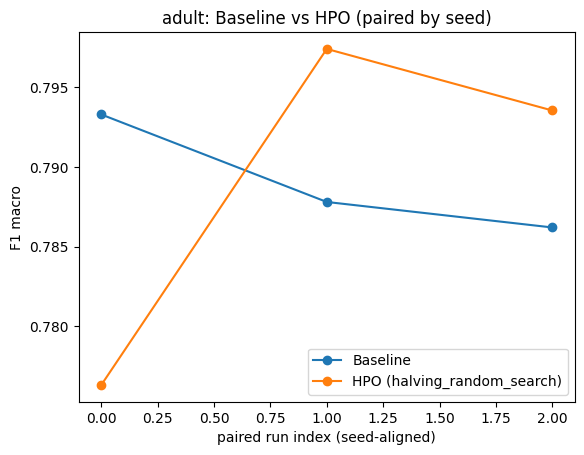

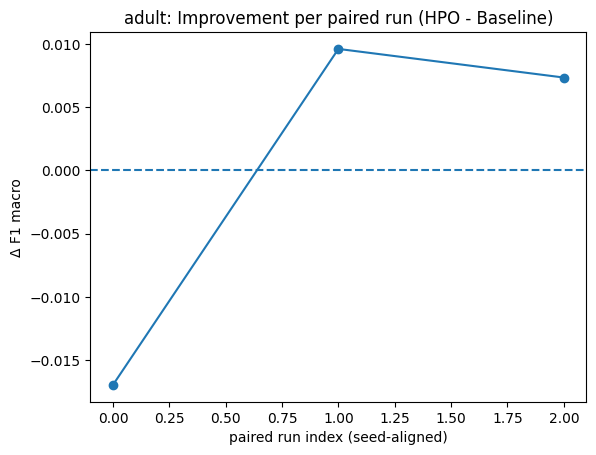

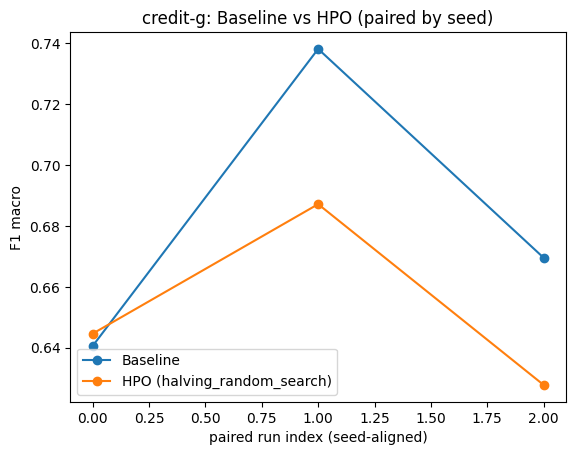

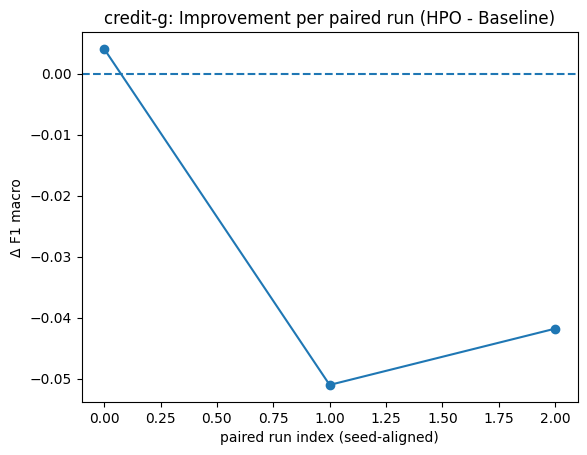

In [15]:
for ds in paired["dataset"].unique():
    g = paired[paired["dataset"] == ds].sort_values("seed")
    x = np.arange(len(g))

    plt.figure()
    plt.plot(x, g["f1_baseline"].to_numpy(), marker="o", label="Baseline")
    plt.plot(x, g["f1_hpo"].to_numpy(), marker="o", label=f"HPO ({METHOD_TO_TEST})")
    plt.title(f"{ds}: Baseline vs HPO (paired by seed)")
    plt.xlabel("paired run index (seed-aligned)")
    plt.ylabel("F1 macro")
    plt.legend()
    plt.show()

    plt.figure()
    plt.axhline(0, linestyle="--")
    plt.plot(x, g["diff"].to_numpy(), marker="o")
    plt.title(f"{ds}: Improvement per paired run (HPO - Baseline)")
    plt.xlabel("paired run index (seed-aligned)")
    plt.ylabel("Δ F1 macro")
    plt.show()


Conclusion

In [16]:
for _, row in stats_df.iterrows():
    ds = row["dataset"]
    print(f"\nDataset: {ds}")
    print(f"Pairs used: {int(row['n_pairs'])}")
    print(f"Mean improvement (ΔF1): {row['mean_diff']:.4f}  |  95% CI [{row['ci95_mean_diff_lo']:.4f}, {row['ci95_mean_diff_hi']:.4f}]")
    print(f"Wilcoxon p-value (HPO > Baseline): {row['p_value_wilcoxon_greater']}")
    print(f"Paired t-test p-value: {row['p_value_paired_ttest']}")
    print("Meets ≥ 0.05 absolute improvement?",
          "YES" if row["mean_diff"] >= 0.05 else "NO")



Dataset: adult
Pairs used: 3
Mean improvement (ΔF1): -0.0000  |  95% CI [-0.0170, 0.0096]
Wilcoxon p-value (HPO > Baseline): 0.625
Paired t-test p-value: 0.9992817643628167
Meets ≥ 0.05 absolute improvement? NO

Dataset: credit-g
Pairs used: 3
Mean improvement (ΔF1): -0.0296  |  95% CI [-0.0510, 0.0040]
Wilcoxon p-value (HPO > Baseline): 0.875
Paired t-test p-value: 0.22426595153267215
Meets ≥ 0.05 absolute improvement? NO
